In [1]:
from preprocess.graph import graph_topology_5_1
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor_1

from losses.loss import gate_loss, water_level_threshold
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from postprocess.threshold import flood_threshold, drought_threshold, flood_threshold_t1, drought_threshold_t1
from spektral.layers import GCNConv

import random

random.seed(10)
print(random.random())

2023-08-17 16:33:13.624309: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 16:33:14.860766: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


0.5714025946899135


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [4]:
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor_1(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


### Graph topology

In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5_1(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Model

In [15]:
saved_model = load_model('saved_models/gtnp_gtnp_13.h5',
                         custom_objects={'gate_loss':gate_loss, 
                                         'water_level_threshold':water_level_threshold,
                                         'GCNConv': GCNConv
                                        }
                        )

2023-08-17 16:33:56.992899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:89:00.0, compute capability: 6.1


In [17]:
start_time = time.perf_counter()


gate_pump_pred, ws_pred = saved_model.predict([test_cov, test_tws_reshape, test_adj_mat])

print(gate_pump_pred.shape)
print(ws_pred.shape)


end_time = time.perf_counter()
used_time = end_time - start_time
print(f"Usded time: {used_time} seconds")

603/603 [==============================] - 4s 7ms/step
(19268, 24, 7)
(19268, 96)
Usded time: 4.875688308849931 seconds


#### ws pred, gate pred

In [18]:
ws_pred_gate_pred_inv = ws_scaler.inverse_transform(ws_pred)
ws_pred_gate_pred_inv = ws_pred_gate_pred_inv.reshape((-1, K, 4))
ws_pred_gate_pred_inv.shape

(19268, 24, 4)

#### ws true, gate true

In [19]:
ws_true_gate_true = test_ws_y
ws_true_gate_true_inv = ws_scaler.inverse_transform(ws_true_gate_true)
ws_true_gate_true_inv = ws_true_gate_true_inv.reshape((-1, K, 4))
ws_true_gate_true_inv.shape

(19268, 24, 4)

#### ws pred, gate true

In [20]:
ws_predictor = load_model('saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

ws_pred_gate_true = ws_predictor.predict([test_cov, test_tws_reshape, test_adj_mat])
ws_pred_gate_true_inv = ws_scaler.inverse_transform(ws_pred_gate_true)
ws_pred_gate_true_inv = ws_pred_gate_true_inv.reshape((-1, 24, 4))
ws_pred_gate_true_inv.shape

603/603 [==============================] - 2s 3ms/step


(19268, 24, 4)

### Upper threshould

In [21]:
upper_threshold = 3.5
t1 = 1

flood_threshold_t1(ws_true_gate_true_inv, t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_true_inv, t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_pred_inv, t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 96, 96, 118, 117
S1, S25A, S25B, S26 areas: 14.82, 15.22, 18, 20.13
TOTAL time steps: 427; TOTAL areas: 68.61
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 85, 85, 96, 108
S1, S25A, S25B, S26 areas: 11.5466, 12.1773, 13, 17.2181
TOTAL time steps: 374; TOTAL areas: 54.3063
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 22, 24, 26, 42
S1, S25A, S25B, S26 areas: 2.2335, 2.6328, 2, 4.945
TOTAL time steps: 114; TOTAL areas: 12.0997
--------------------------------------------------


In [22]:
flood_threshold_t1(ws_true_gate_true_inv[7640-23:7680-23], t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_true_inv[7640-23:7680-23], t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_pred_inv[7640-23:7680-23], t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 6, 5, 6, 6
S1, S25A, S25B, S26 areas: 0.84, 0.72, 1, 1.0
TOTAL time steps: 23; TOTAL areas: 3.62
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 6, 6, 5, 5
S1, S25A, S25B, S26 areas: 0.6148, 0.6425, 1, 0.8663
TOTAL time steps: 22; TOTAL areas: 3.0018
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 1, 1, 1, 2
S1, S25A, S25B, S26 areas: 0.0251, 0.055, 0, 0.117
TOTAL time steps: 5; TOTAL areas: 0.2258
--------------------------------------------------


In [23]:
flood_threshold(ws_true_gate_true_inv, upper_threshold)
flood_threshold(ws_pred_gate_true_inv, upper_threshold)
flood_threshold(ws_pred_gate_pred_inv, upper_threshold)

time steps: 10248, areas: 1646.6399002075195
time steps: 12130, areas: 2088.0380942821503
time steps: 7885, areas: 1263.7411830425262


### Lower threshold

In [24]:
lower_threshold = 0
t1 = 1

drought_threshold_t1(ws_true_gate_true_inv, t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_true_inv, t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_pred_inv, t1, lower_threshold)

S1, S25A, S25B, S26 time steps: 1346, 1341, 1229, 1250
S1, S25A, S25B, S26 areas: -385.8, -383.38, -345.08, -350.84:
TOTAL time steps: 5166; TOTAL areas: -1465.1
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 1390, 1427, 1282, 1476
S1, S25A, S25B, S26 areas: -398.849, -392.0414, -350.2885, -429.5386:
TOTAL time steps: 5575; TOTAL areas: -1570.7176
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 299, 152, 37, 129
S1, S25A, S25B, S26 areas: -53.3481, -23.0246, -3.7959, -18.2518:
TOTAL time steps: 617; TOTAL areas: -98.4204
--------------------------------------------------


In [25]:
drought_threshold_t1(ws_true_gate_true_inv[7640-23:7680-23], t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_true_inv[7640-23:7680-23], t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_pred_inv[7640-23:7680-23], t1, lower_threshold)

S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------


In [26]:
drought_threshold(ws_true_gate_true_inv, lower_threshold)
drought_threshold(ws_pred_gate_true_inv, lower_threshold)
drought_threshold(ws_pred_gate_pred_inv, lower_threshold)

time steps: 124148, areas: 35182.6098122485
time steps: 127126, areas: 34960.07284716559
time steps: 12712, areas: 2165.9208305822167


In [27]:
ws_true_gate_true_inv_24 = ws_true_gate_true_inv[:, t1, :]
ws_pred_gate_true_inv_24 = ws_pred_gate_true_inv[:, t1, :]
ws_pred_gate_pred_inv_24 = ws_pred_gate_pred_inv[:, t1, :]

ws_true_gate_true_inv_24 = ws_true_gate_true_inv_24.reshape((-1, 1, 4))
ws_pred_gate_true_inv_24 = ws_pred_gate_true_inv_24.reshape((-1, 1, 4))
ws_pred_gate_pred_inv_24 = ws_pred_gate_pred_inv_24.reshape((-1, 1, 4))

drought_threshold(ws_true_gate_true_inv_24, lower_threshold)
drought_threshold(ws_pred_gate_true_inv_24, lower_threshold)
drought_threshold(ws_pred_gate_pred_inv_24, lower_threshold)

time steps: 5166, areas: 1465.099992136471
time steps: 5575, areas: 1570.7175889443388
time steps: 617, areas: 98.42042673812102


### Visualization

In [28]:
def flood_check(array, threshold):
    flood_idx = []

    for i in range(len(array)):
        if np.any(array[i, :, 0] > threshold) & np.any(array[i, :, 1] > threshold) & np.any(array[i, :, 2] > threshold) & np.any(array[i, :, 3] > threshold):   # flooding condition
            flood_idx.append(i)

    return len(flood_idx), flood_idx

In [29]:
upper_threshold = 3.5
flood_check(ws_true_gate_true_inv, upper_threshold)

(749,
 [7604,
  7605,
  7606,
  7607,
  7608,
  7609,
  7610,
  7611,
  7612,
  7613,
  7614,
  7615,
  7616,
  7617,
  7618,
  7619,
  7620,
  7621,
  7622,
  7623,
  7624,
  7625,
  7626,
  7627,
  7628,
  7629,
  7630,
  7631,
  7632,
  7633,
  7634,
  7635,
  7636,
  7637,
  7638,
  7639,
  7640,
  7641,
  7642,
  7643,
  7644,
  7645,
  7646,
  7647,
  7648,
  7649,
  7650,
  7651,
  7652,
  8212,
  8213,
  8214,
  8215,
  8216,
  8217,
  8218,
  8219,
  8220,
  8221,
  8222,
  8223,
  8224,
  8225,
  8226,
  8227,
  8228,
  8229,
  8230,
  8231,
  8232,
  8233,
  8234,
  8235,
  8236,
  8237,
  8238,
  8239,
  8240,
  8241,
  8242,
  8243,
  8244,
  8245,
  8246,
  8247,
  8248,
  8249,
  8250,
  8251,
  8252,
  8253,
  8254,
  8255,
  8256,
  8257,
  8258,
  8259,
  8260,
  8261,
  8262,
  8263,
  8264,
  8265,
  8266,
  8267,
  8268,
  8269,
  8270,
  8271,
  8272,
  8273,
  8274,
  8275,
  8276,
  8277,
  8278,
  8279,
  8280,
  8281,
  8282,
  8283,
  8284,
  8285,
  8286,
  

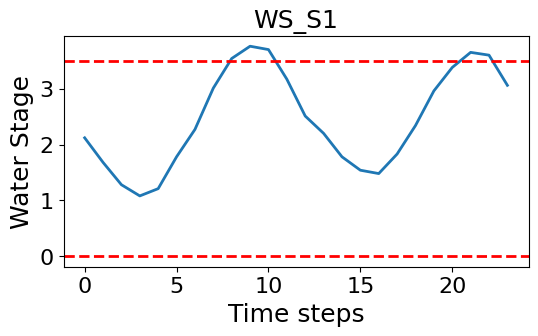

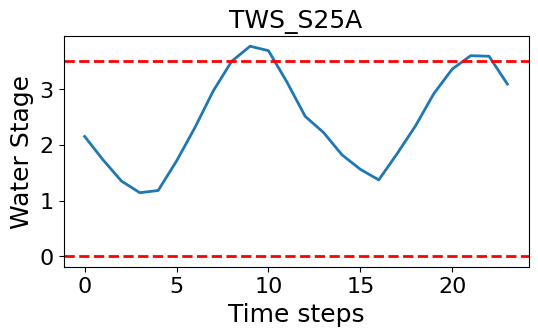

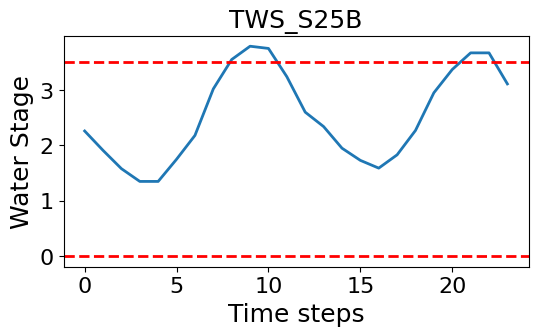

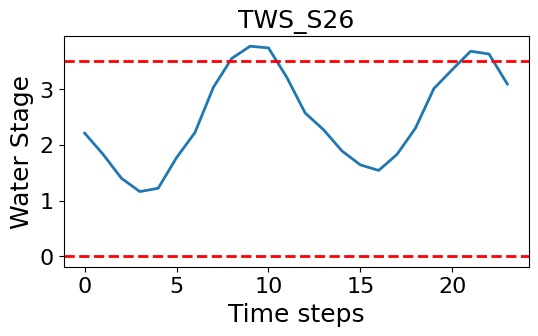

In [30]:
demo = 7630   # 8300
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']

for j in range(len(wss)):
    plt.rcParams["figure.figsize"] = (6, 3)
    plt.plot(ws_true_gate_true_inv[demo, :, j], linewidth=2)
    

    plt.axhline(y = upper_threshold, color='r', linestyle='dashed', linewidth=2)
    plt.axhline(y = 0.0, color='r', linestyle='dashed', linewidth=2)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Water Stage', fontsize=18)
    plt.title('{}'.format(wss[j]), fontsize=18)
    plt.show()

In [31]:
# ================================ gate predict ================================
gate_pump_pred = gate_pump_pred.reshape((-1, 24*7))
print(gate_pump_pred.shape)

gate_pump_pred_inv = gate_scalar.inverse_transform(gate_pump_pred)
gate_pump_pred_inv = gate_pump_pred_inv.reshape((-1, 24, 7))
print(gate_pump_pred_inv.shape)

one_gate_pump_pred_inv = np.round(gate_pump_pred_inv[demo], decimals=1)


# ================================ gate true ================================
test_gate_pump_true = test_gate_pump_y.reshape((-1, test_gate_pump_y.shape[1]*test_gate_pump_y.shape[2]))
print(test_gate_pump_true.shape)

test_gate_pump_true_inv = gate_scalar.inverse_transform(test_gate_pump_true)
test_gate_pump_true_inv = test_gate_pump_true_inv.reshape((-1, 24, 7))
print(test_gate_pump_true_inv.shape)

one_test_gate_pump_true_inv = np.round(test_gate_pump_true_inv[demo], decimals=1)
# one_test_gate_pump_true_inv

(19268, 168)
(19268, 24, 7)
(19268, 168)
(19268, 24, 7)


In [32]:
gates = gate_pump_pred_inv[:, :, :5]
print(gates.max())

pumps = gate_pump_pred_inv[:, :, 5:]
print(pumps.max())

15.050001
630.16


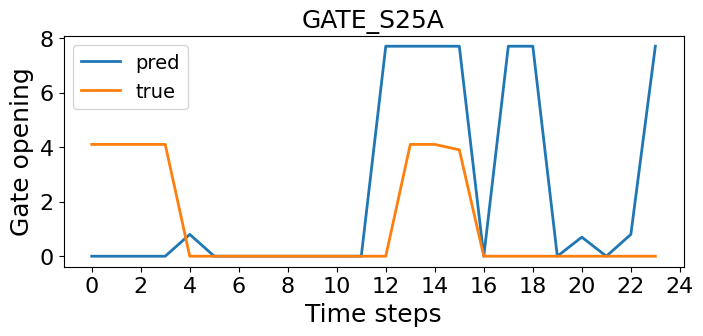

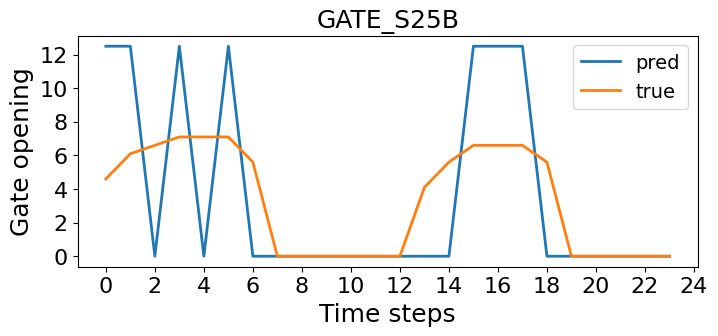

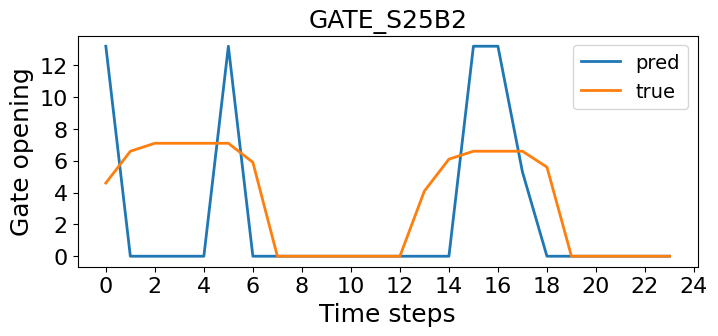

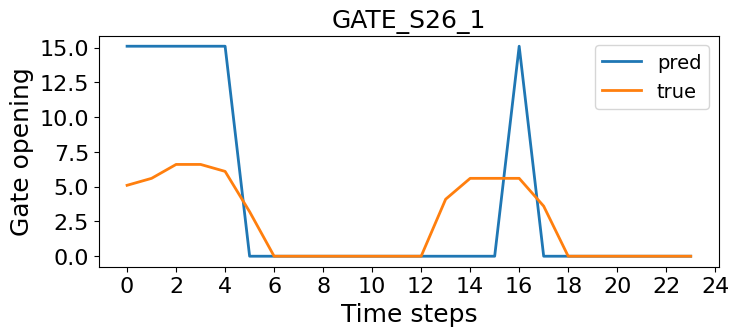

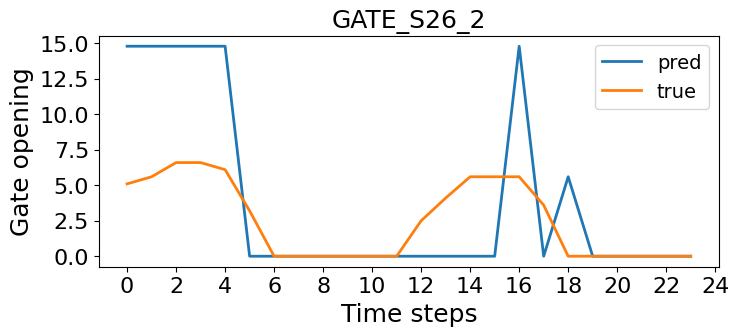

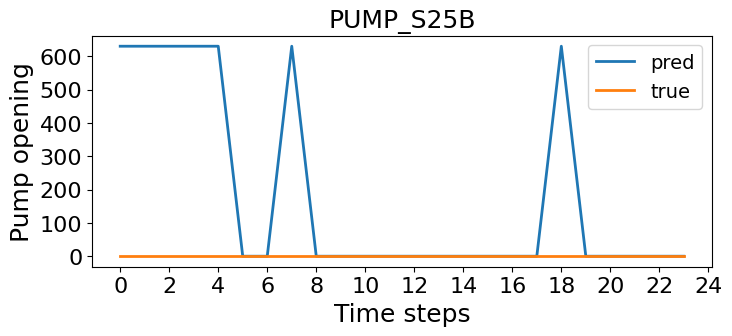

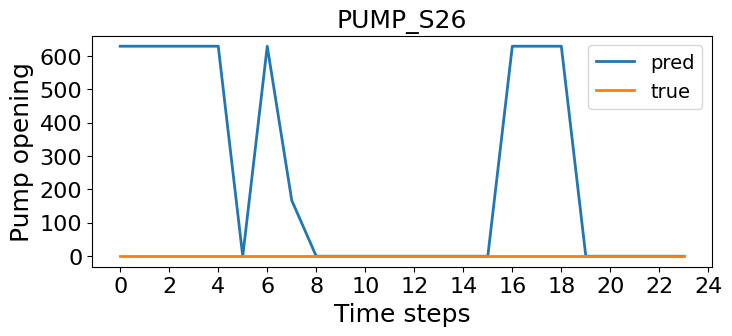

In [33]:
gates_pumps = ['GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S25B', 'PUMP_S26']
time_ticks = [i for i in range(25)]

for i in range(len(gates_pumps)):
    plt.rcParams["figure.figsize"] = (8, 3)
    plt.plot(one_gate_pump_pred_inv[:, i], label='pred', linewidth=2)
    plt.plot(one_test_gate_pump_true_inv[:, i], label='true', linewidth=2)
    plt.xticks(time_ticks[::2], fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    if i < 5:
        plt.ylabel('Gate opening', fontsize=18)
    else:
        plt.ylabel('Pump opening', fontsize=18)
    plt.title('{}'.format(gates_pumps[i]), fontsize=18)
    plt.legend(fontsize=14)
    plt.show()

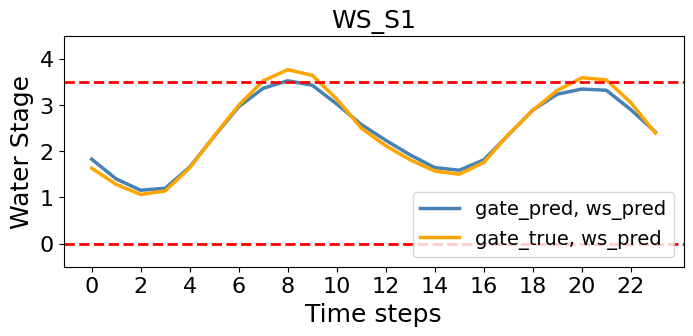

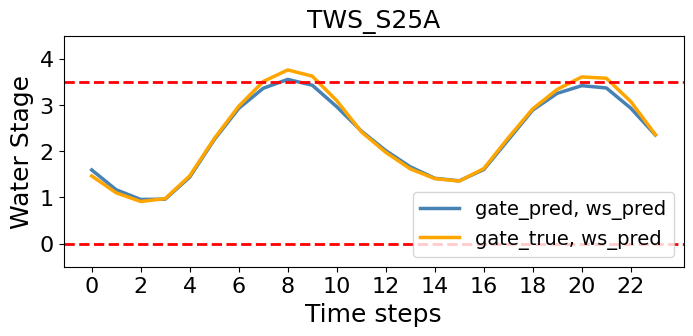

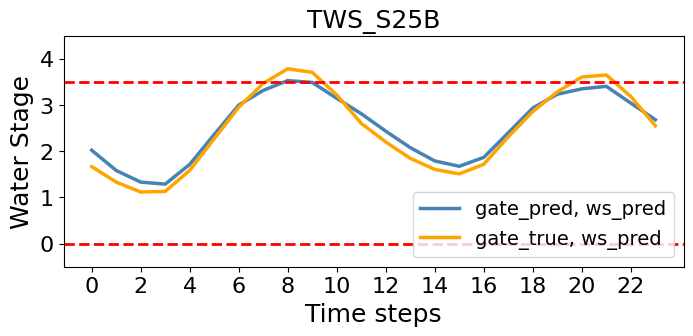

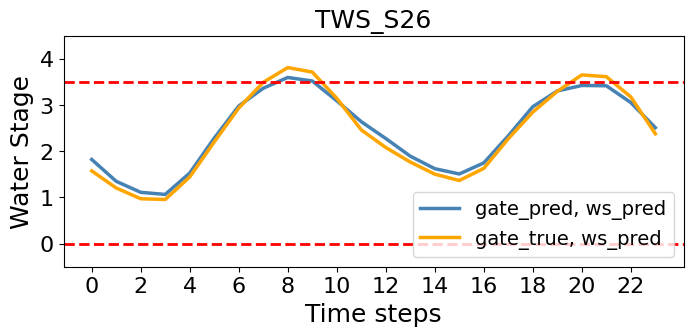

In [34]:
time_ticks = [i for i in range(24)]

wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']

for j in range(len(wss)):
    plt.rcParams["figure.figsize"] = (8, 3)

    plt.plot(ws_pred_gate_pred_inv[demo:demo+24, 1, j], label='gate_pred, ws_pred', linewidth=2.5, color='steelblue')
    plt.plot(ws_pred_gate_true_inv[demo:demo+24, 1, j], label='gate_true, ws_pred', linewidth=2.5, color='orange')
#     plt.plot(ws_true_gate_true_inv[demo, :, j], label='gate_true, ws_true', linewidth=2.5, color='green')


#     plt.plot(ws_pred_gate_pred_inv[demo, :, j], label='gate_pred, ws_pred', linewidth=2.5, color='steelblue')
#     plt.plot(ws_pred_gate_true_inv[demo, :, j], label='gate_true, ws_pred', linewidth=2.5, color='orange')
# #     plt.plot(ws_true_gate_true_inv[demo, :, j], label='gate_true, ws_true', linewidth=2.5, color='green')
    
    plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
    plt.axhline(y = 0.0, color='r', linestyle='dashed', linewidth=2)

    plt.xticks(time_ticks[::2], fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim([-0.5, 4.5])
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Water Stage', fontsize=18)
    plt.title('{}'.format(wss[j]), fontsize=18)
    plt.legend(fontsize=14)
    plt.show()

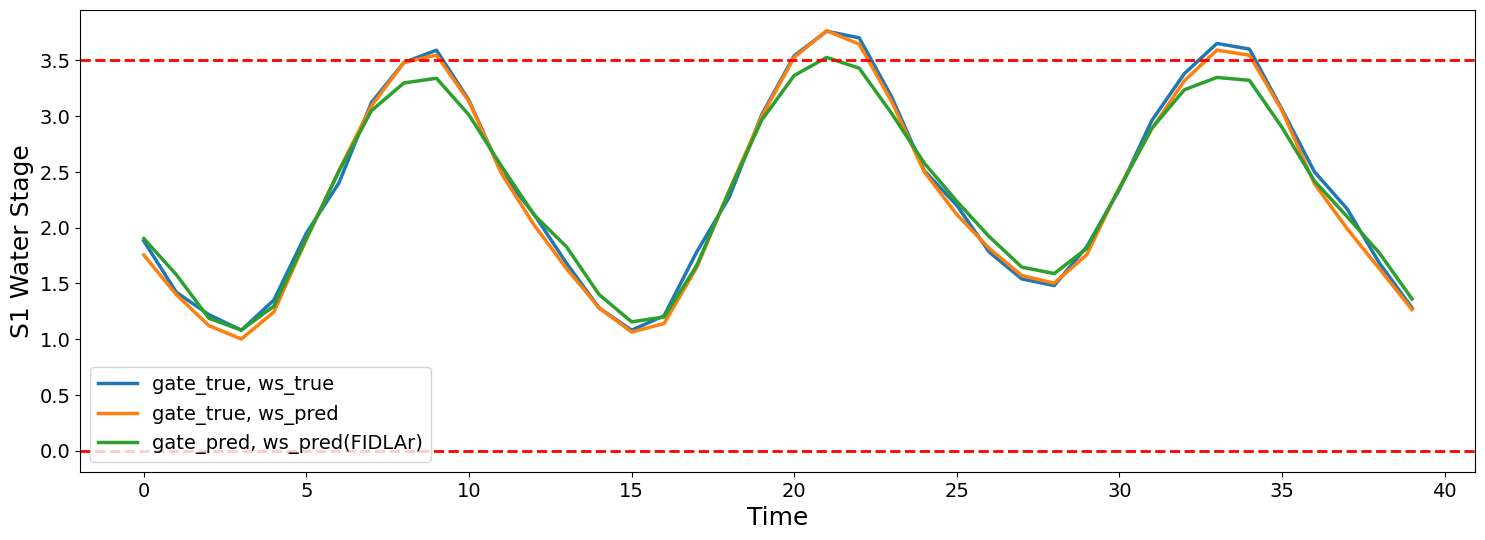

In [35]:
# plt.plot(ws_pred_gate_pred_inv[7640+43:7680+43, 1, 0], label='gate_pred, ws_pred', linewidth=2.5, color='steelblue')


plt.rcParams["figure.figsize"] = (18, 6)
# plt.plot(ws_true_gate_true_inv[7640:7680, 1, 0], label='ground')
# plt.plot(ws_pred_gate_true_inv[7640:7680, 1, 0], label='pred')
# plt.plot(ws_pred_gate_pred_inv[7640:7680, 1, 0], label='FIDLA')

plt.plot(ws_true_gate_true_inv[7640-23:7680-23, 1, 0], label='gate_true, ws_true', linewidth=2.5)
plt.plot(ws_pred_gate_true_inv[7640-23:7680-23, 1, 0], label='gate_true, ws_pred', linewidth=2.5)
plt.plot(ws_pred_gate_pred_inv[7640-23:7680-23, 1, 0], label='gate_pred, ws_pred(FIDLAr)', linewidth=2.5)
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.axhline(y = 0, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [36]:
true_true = ws_true_gate_true_inv[7640-23:7680-23, 1, 0]
true_true[true_true>3.5]

array([3.59, 3.54, 3.76, 3.7 , 3.65, 3.6 ], dtype=float32)